# 02 — Forecast plus Drivers
Add a seasonal baseline and driver insights (feature importance or SHAP).

In [4]:
# Cell 0 - imports and data path
import numpy as np, pandas as pd
from pathlib import Path

np.random.seed(42)

candidates = [
    Path("../data/sample_transactions.csv"),
    Path("data/sample_transactions.csv"),
    Path.cwd().parent / "data" / "sample_transactions.csv",
]
for p in candidates:
    if p.exists():
        DATA = p
        break
else:
    raise FileNotFoundError("sample_transactions.csv not found")

print("data file:", DATA)


# Cell 1 - Weekly Panel

df = pd.read_csv(DATA, parse_dates=["date"])
df["week"] = df["date"].dt.to_period("W").apply(lambda r: r.start_time)
agg = (df.groupby(["week","product","region"], as_index=False)
         .agg(qty=("qty","sum"),
              price=("price","mean"),
              promo=("promo","mean")))
agg = agg.sort_values(["product","region","week"]).reset_index(drop=True)
agg["key"] = agg["product"] + "_" + agg["region"]
agg.head()





data file: ../data/sample_transactions.csv


,week,product,region,qty,price,promo,key
0,2024-01-01,A,East,67,23.995000,0.000000,A_East
1,2024-01-08,A,East,36,28.450000,0.000000,A_East
2,2024-01-15,A,East,68,24.885000,0.000000,A_East
3,2024-01-22,A,East,170,20.292000,0.000000,A_East
4,2024-01-29,A,East,104,22.563333,0.333333,A_East


In [5]:
# Cell 2 - seasonal baseline with index-safe transform
# sort so rolling is computed in time order per key
agg = agg.sort_values(["product", "region", "week"]).reset_index(drop=True)
agg["key"] = agg["product"] + "_" + agg["region"]

# 4-week seasonal baseline, shifted by 1 to avoid leakage
agg["baseline_4w"] = (
    agg.groupby("key")["qty"]
       .transform(lambda s: s.shift(1).rolling(4, min_periods=4).mean())
)

# keep only rows where the baseline is available
panel = agg[agg["baseline_4w"].notna()].copy()

# features
panel["week_of_year"] = panel["week"].dt.isocalendar().week.astype(int)
panel["month"] = panel["week"].dt.month

FEATS = ["price", "promo", "week_of_year", "month"]
X = panel[FEATS].copy()
y = panel["qty"].copy()
base = panel["baseline_4w"].copy()


In [6]:
# Cell 3 - time based split with aligned indexes
# keep panel time-ordered
panel = panel.sort_values("week").reset_index(drop=True)

# rebuild X, y, base from the ordered panel to be safe
X = panel[FEATS].copy()
y = panel["qty"].copy()
base = panel["baseline_4w"].copy()

split_idx = int(len(panel) * 0.8)

# split and reset indexes so shapes and indexes match downstream
X_train = X.iloc[:split_idx].reset_index(drop=True)
X_test  = X.iloc[split_idx:].reset_index(drop=True)

y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test  = y.iloc[split_idx:].reset_index(drop=True)

base_train = base.iloc[:split_idx].reset_index(drop=True)
base_test  = base.iloc[split_idx:].reset_index(drop=True)

len(X_train), len(X_test), len(y_train), len(y_test), len(base_test)


(236, 60, 236, 60, 60)

In [7]:
# Cell 4 - model vs seasonal baseline 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mae_base = mean_absolute_error(y_test, base_test)
mae_model = mean_absolute_error(y_test, pred)
rmse_base = float(np.sqrt(mean_squared_error(y_test, base_test)))
rmse_model = float(np.sqrt(mean_squared_error(y_test, pred)))
uplift = 100.0 * (mae_base - mae_model) / mae_base

print({
    "MAE_baseline(seasonal_4w)": round(mae_base,2),
    "MAE_model": round(mae_model,2),
    "RMSE_baseline": round(rmse_base,2),
    "RMSE_model": round(rmse_model,2),
    "Uplift_pct_MAE": round(uplift,1)
})

{'MAE_baseline(seasonal_4w)': 24.45, 'MAE_model': 18.42, 'RMSE_baseline': 29.24, 'RMSE_model': 23.93, 'Uplift_pct_MAE': 24.7}


price           0.470035
promo           0.324059
week_of_year    0.170394
month           0.035512
dtype: float64

Saved: figures/day2_feature_importances.csv figures/day2_partial_price.png figures/day2_partial_promo.png


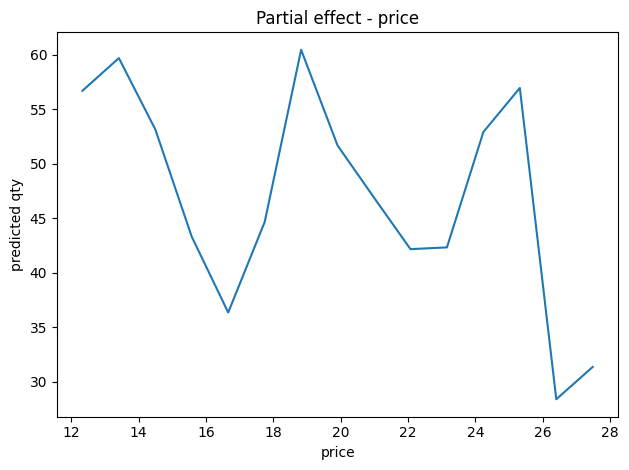

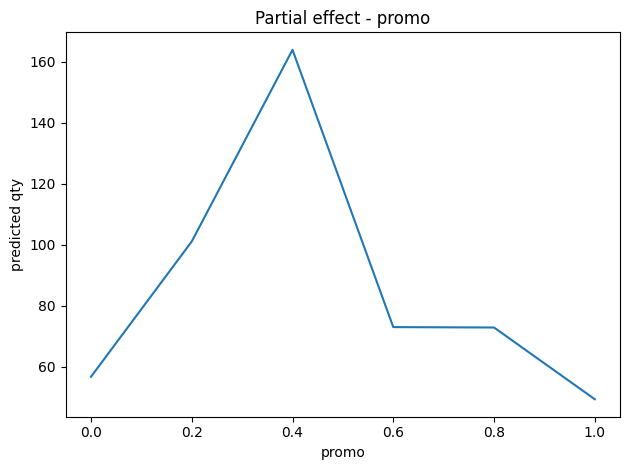

In [8]:
# Cell 5 - driver insights and partial plots (self contained)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display  # needed in VS Code notebooks

figdir = Path("figures")
figdir.mkdir(exist_ok=True)

# importances
imp = pd.Series(rf.feature_importances_, index=FEATS).sort_values(ascending=False)
imp.to_csv(figdir / "day2_feature_importances.csv")
display(imp)

# simple partial effects
def partial_effect(model, X_ref, feat, grid):
    X_tmp = X_ref.copy()
    preds = []
    for g in grid:
        X_tmp[feat] = g
        preds.append(model.predict(X_tmp).mean())
    return preds

X_ref = X_train.copy()
for col in X_ref.columns:
    X_ref[col] = X_ref[col].median()

price_grid = np.linspace(X_train["price"].quantile(0.05), X_train["price"].quantile(0.95), 15)
promo_grid = np.linspace(0, 1, 6)

plt.figure()
plt.plot(price_grid, partial_effect(rf, X_ref, "price", price_grid))
plt.xlabel("price"); plt.ylabel("predicted qty"); plt.title("Partial effect - price")
plt.tight_layout(); plt.savefig(figdir / "day2_partial_price.png")

plt.figure()
plt.plot(promo_grid, partial_effect(rf, X_ref, "promo", promo_grid))
plt.xlabel("promo"); plt.ylabel("predicted qty"); plt.title("Partial effect - promo")
plt.tight_layout(); plt.savefig(figdir / "day2_partial_promo.png")

print("Saved:", figdir / "day2_feature_importances.csv",
      figdir / "day2_partial_price.png", figdir / "day2_partial_promo.png")


Saved: figures/day2_actual_model_baseline.png


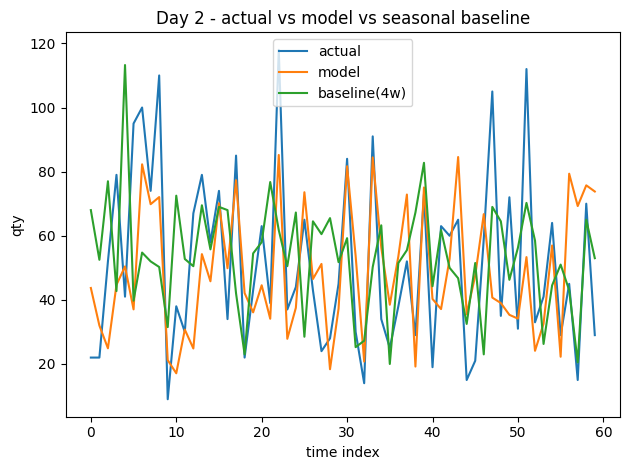

In [9]:
# Cell 6 - actual vs model vs seasonal baseline (self contained)
import matplotlib.pyplot as plt
from pathlib import Path

figdir = Path("figures")
figdir.mkdir(exist_ok=True)

plt.figure()
plt.plot(range(len(y_test)), y_test.values, label="actual")
plt.plot(range(len(y_test)), pred, label="model")
plt.plot(range(len(y_test)), base_test.values, label="baseline(4w)")
plt.legend(); plt.xlabel("time index"); plt.ylabel("qty")
plt.title("Day 2 - actual vs model vs seasonal baseline")
plt.tight_layout(); plt.savefig(figdir / "day2_actual_model_baseline.png")
print("Saved:", figdir / "day2_actual_model_baseline.png")

In [10]:
# Cell 7 - Business Readout 
lines = [
    f"Against a seasonal 4-week baseline, model reduces MAE by {uplift:.1f}%.",
    f"Top drivers: {', '.join(imp.index[:2])}.",
    "Price partial shows expected negative slope; promo partial shows positive lift.",
    "Use seasonal baseline for safety stock; use model to prioritize promo/price cells.",
    "Next: add calendar features (holidays) and region segmentation for stability."
]
Path("SO_WHAT_DAY2.txt").write_text("So what (Day 2):\n- " + "\n- ".join(lines))
print("\n".join(lines))

Against a seasonal 4-week baseline, model reduces MAE by 24.7%.
Top drivers: price, promo.
Price partial shows expected negative slope; promo partial shows positive lift.
Use seasonal baseline for safety stock; use model to prioritize promo/price cells.
Next: add calendar features (holidays) and region segmentation for stability.


In [11]:
# Day 2 verification cell - keep at the very end
from pathlib import Path
import numpy as np, pandas as pd
import json

errors = []

# 1) Required variables should exist if you ran the notebook top to bottom
required = ["panel","X_train","X_test","y_train","y_test","base_test","pred","imp","uplift","mae_base","mae_model"]
for v in required:
    if v not in globals():
        errors.append(f"Missing variable: {v}")

# 2) Seasonal baseline sanity
if "panel" in globals():
    if panel["baseline_4w"].isna().mean() > 0.05:
        errors.append("Too many NaNs in seasonal baseline. Check rolling window and mask.")

# 3) Train-test sanity
if "X_train" in globals() and "X_test" in globals():
    if len(X_train) == 0 or len(X_test) == 0:
        errors.append("Train or test split is empty. Check split_idx.")

# 4) Metrics sanity
try:
    assert np.isfinite(mae_base) and np.isfinite(mae_model)
    assert mae_base > 0 and mae_model > 0
except Exception:
    errors.append("MAE values are not finite and positive.")

direction = "improved" if "uplift" in globals() and uplift > 0 else "worse"

# 5) Files exist
figdir = Path("figures")
expected = [
    figdir / "day2_actual_model_baseline.png",
    figdir / "day2_partial_price.png",
    figdir / "day2_partial_promo.png",
    figdir / "day2_feature_importances.csv",
]
missing = [str(p) for p in expected if not p.exists()]

# 6) Importances top 2
top_features = None
fi_path = figdir / "day2_feature_importances.csv"
if fi_path.exists():
    fi = pd.read_csv(fi_path, header=None)
    if fi.shape[1] == 2:
        fi.columns = ["feature","importance"]
        top_features = list(fi.sort_values("importance", ascending=False)["feature"].head(2))
    else:
        top_features = list(fi.iloc[:,0].head(2))
else:
    errors.append("Missing day2_feature_importances.csv")

report = {
    "len_train": len(X_train) if "X_train" in globals() else None,
    "len_test": len(X_test) if "X_test" in globals() else None,
    "MAE_baseline_seasonal": round(float(mae_base), 3) if "mae_base" in globals() else None,
    "MAE_model": round(float(mae_model), 3) if "mae_model" in globals() else None,
    "Uplift_pct_MAE": round(float(uplift), 1) if "uplift" in globals() else None,
    "Direction_vs_baseline": direction,
    "Top_features": top_features,
    "Missing_figures": missing,
    "Errors": errors,
}
print(json.dumps(report, indent=2))


{
  "len_train": 236,
  "len_test": 60,
  "MAE_baseline_seasonal": 24.454,
  "MAE_model": 18.421,
  "Uplift_pct_MAE": 24.7,
  "Direction_vs_baseline": "improved",
  "Top_features": [
    "price",
    "promo"
  ],
  "Missing_figures": [],
  "Errors": []
}
